# Bias Mitigation in Clinical Records

## Problem statement

Cardiovascular diseases (CVDs) remain a major health concern worldwide, causing the deaths of approximately 17 million people annually. Among these, heart failure (HF) is particularly notable, occurring when the heart cannot pump sufficient blood to meet the body's needs. HF is often a consequence of conditions such as diabetes and high blood pressure. Clinically, heart failure is categorized into two types based on the ejection fraction: heart failure with reduced ejection fraction (HFrEF) and heart failure with preserved ejection fraction (HFpEF). Despite advances in medical research, predicting survival outcomes for heart failure patients and identifying critical predictive factors remains challenging.

Traditional biostatistical models, such as Cox regression and Kaplan-Meier survival plots, have been widely used but often result in modest accuracy and limited interpretability. The study of machine learning (ML) models has gained traction in recent years, offering the potential to improve predictive performance and provide insights into the underlying relationships between variables. However, the use of ML models in clinical settings raises concerns about fairness, as these models may inadvertently discriminate against certain groups of patients or generate disparate outcomes based on sensitive attributes.

In this case study, we evaluate bias in clinical records of hearth failure. We use the dataset available in [UCI Repository](https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records). 

In [14]:
from holisticai.datasets import load_dataset

dataset = load_dataset('clinical_records', protected_attribute="sex")
dataset['sex'] = dataset['p_attrs']['sex'].map(lambda x: 'Female' if x==1 else "Male")
dataset

## Exploratory data analysis

The dataset analyzed in this study consists of medical records of 299 heart failure patients collected from the Faisalabad Institute of Cardiology and Allied Hospital in Faisalabad, Pakistan, during April-December 2015. The cohort includes 105 women and 194 men, aged between 40 and 95 years, all of whom had left ventricular systolic dysfunction and previous heart failures classified as class III or IV by the New York Heart Association (NYHA).

The dataset includes 13 features capturing clinical, bodily, and lifestyle information:

- anaemia: Presence of anemia (0 = no, 1 = yes)
- high_blood_pressure: Presence of hypertension (0 = no, 1 = yes)
- creatinine_phosphokinase (CPK): Level of the CPK enzyme in the blood (mcg/L)
- diabetes: Presence of diabetes (0 = no, 1 = yes)
- ejection_fraction: Percentage of blood leaving the heart at each contraction
- serum_creatinine: Level of creatinine in the blood (mg/dL)
- Platelets: Platelet count (kiloplatelets/mL)
- serum_sodium: Sodium level in the blood (mEq/L)
- sex: Gender of the patient (0 = female, 1 = male)
    - we will consider group A as female and group B as male
- smoking: Whether the patient is a smoker (0 = no, 1 = yes)
- time: Follow-up period (days)
- y - target variable: Whether the patient died during the follow-up period (0 = no, 1 = yes)

In [15]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
# Basic information
dataset.data.info()

# Print the number of deaths and survivals
print(dataset['y'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   (X, anaemia)                   299 non-null    int64  
 1   (X, creatinine_phosphokinase)  299 non-null    int64  
 2   (X, diabetes)                  299 non-null    int64  
 3   (X, ejection_fraction)         299 non-null    int64  
 4   (X, high_blood_pressure)       299 non-null    int64  
 5   (X, platelets)                 299 non-null    float64
 6   (X, serum_creatinine)          299 non-null    float64
 7   (X, serum_sodium)              299 non-null    int64  
 8   (X, smoking)                   299 non-null    int64  
 9   (X, time)                      299 non-null    int64  
 10  (y, y)                         299 non-null    int64  
 11  (p_attrs, age)                 299 non-null    float64
 12  (p_attrs, sex)                 299 non-null    int

With basic informations about the dataset, we can observe that the majority of variables are integers, and the dataset don't have missing values. The target variable is binary, with 96 patients dying during the follow-up period and 203 surviving. The dataset is unbalanced, with 32% of the patients dying during the follow-up period. Next, we will evaluate the number of deaths by group A and group B.

In [17]:
dataset['sex']

0      Female
1      Female
2      Female
3      Female
4        Male
        ...  
294    Female
295      Male
296      Male
297    Female
298    Female
Name: sex, Length: 299, dtype: object

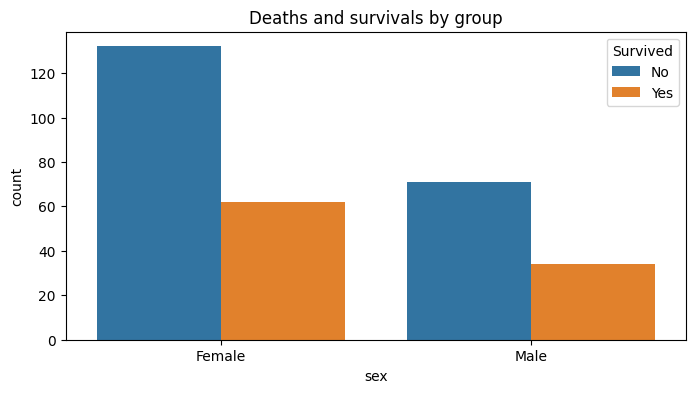

In [18]:
# Deaths and survivals by group
plt.figure(figsize=(8, 4))
sns.countplot(x=dataset['sex'], hue=dataset['y'])
plt.title('Deaths and survivals by group')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()   

In [19]:
dataset

In [20]:
dataset.groupby(['sex','y']).count()

,sex,y,group_size
0,Female,0,132
1,Female,1,62
2,Male,0,71
3,Male,1,34


We observe that the number of deaths is higher in Group B compared to Group A. This difference might be attributed to the higher number of males in the dataset. Notably, the percentage of deaths is similar for both groups. To understand this disparity further, we can conduct a more in-depth analysis of the dataset to determine if other factors contribute to this difference.

In [21]:
# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset['X'])
data_scaled = pd.DataFrame(scaled_features, columns=dataset['X'].columns)

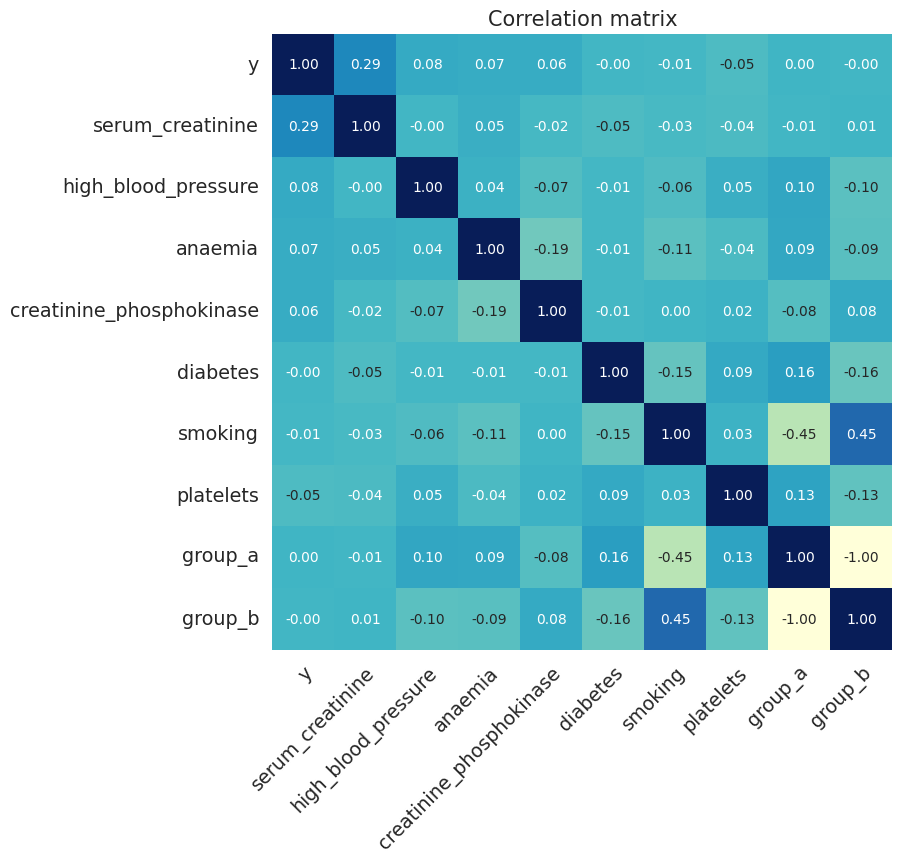

In [22]:
# Correlation matrix
from holisticai.datasets.plots import correlation_matrix_plot

correlation_matrix_plot(dataset, features = ['X'], fixed_features=['group_a','group_b'], target_feature='y',  size=(8, 8), n_features=10)

plt.show()

The correlation matrix shows that the target variabl (death event) is positively correlated with serum creatinine, and negatively correlated with ejection fraction. These results are consistent with the clinical literature ([[1]](https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.105.561423), [[2]](https://www.nejm.org/doi/pdf/10.1056/NEJMoa041031)), which suggests that patients with higher serum creatinine levels and lower ejection fractions are at higher risk of death.

Another important correlation obsverved is between the groups as we can see that the group B is positively correlated with smoking and negatively correlated with group A.

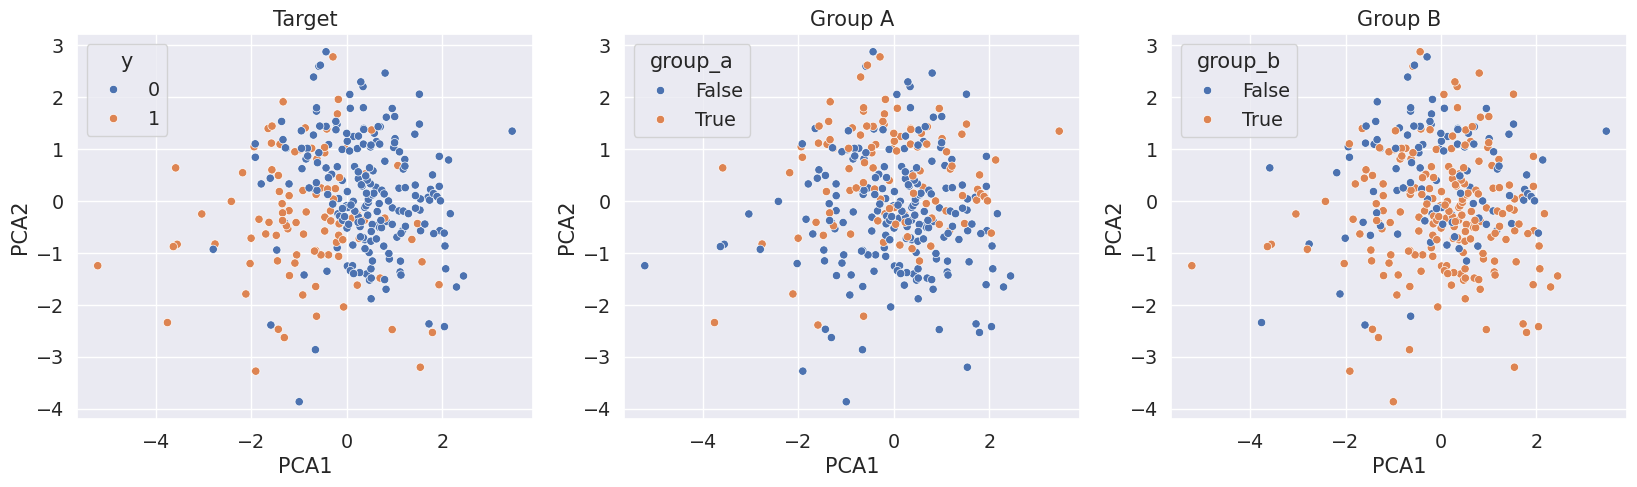

In [23]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)
df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_pca['y'] = dataset['y']
df_pca['group_a'] = dataset['group_a']
df_pca['group_b'] = dataset['group_b']

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='y', data=df_pca, ax=axs[0]).set_title('Target')
sns.scatterplot(x='PCA1', y='PCA2', hue='group_a', data=df_pca, ax=axs[1]).set_title('Group A')
sns.scatterplot(x='PCA1', y='PCA2', hue='group_b', data=df_pca, ax=axs[2]).set_title('Group B')
plt.show()

In the figures above we observe the Principal Component Analysis (PCA) considering the target variable and the groups. The PCA shows that the dataset is not linearly separable for groups, which suggests that the groups are not well defined by the features in the dataset. This result is consistent with the correlation matrix, which shows that the groups are not strongly correlated with the other features (except with smoking).

To chose an appropriate number of clusters we can use the elbow methods and compute the silhouette score. The elbow method suggests that the optimal number of clusters is 8, which is consistent with the number of groups in the dataset. The silhouette score also suggests that the optimal number of clusters is 8-9, with a score of 0.1290. This result indicates that the dataset is not well clustered, which is consistent with the PCA results.

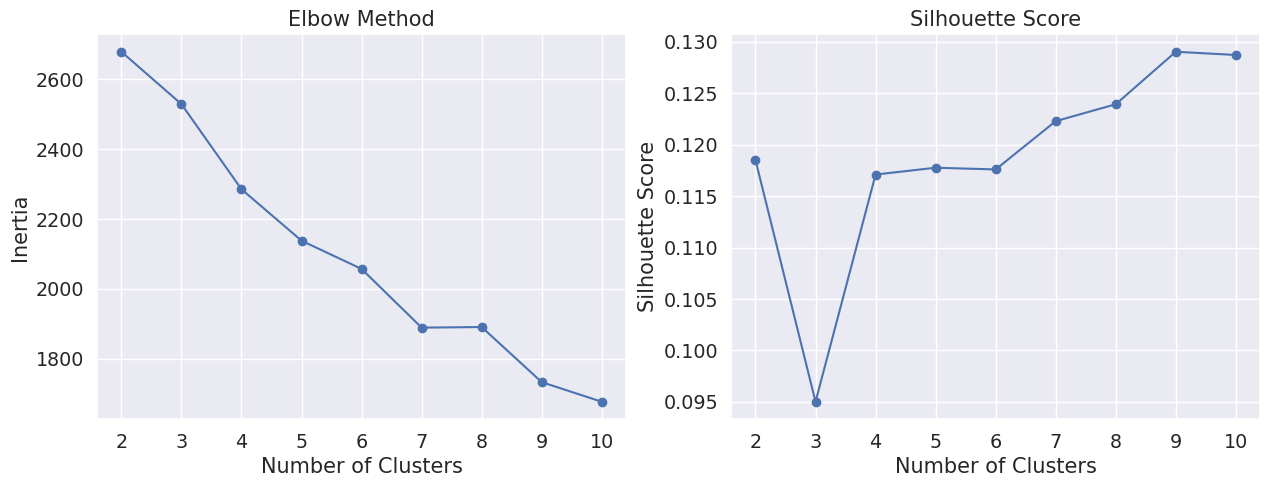

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters using the elbow method
inertia = []
silhouette_scores = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plot the elbow method results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(range(2, 11), inertia, marker='o')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Inertia')
axs[1].plot(range(2, 11), silhouette_scores, marker='o')
axs[1].set_title('Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette Score')
plt.show()

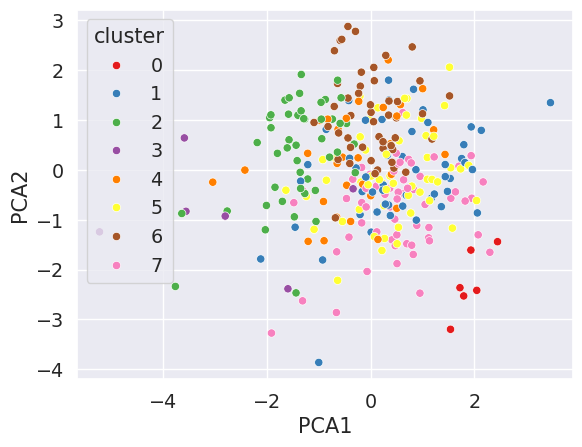

In [25]:
# Apply KMeans with the optimal number of clusters
optimal_clusters = 8  # Assuming 3 is optimal based on previous plots
kmeans = KMeans(n_clusters=optimal_clusters)
df_pca['cluster'] = kmeans.fit_predict(data_scaled)

sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='Set1', data=df_pca)
plt.show()


In [26]:
# Calculate silhouette score for the optimal clustering
silhouette_avg = silhouette_score(data_scaled, df_pca['cluster'])
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')

Silhouette Score for 8 clusters: 0.14169298354278806


## Fairness evaluation

To ensure that our predictive models are fair, we will evaluate the predictions for bias with respect to the protected attribute sex. We will use the following steps to assess and mitigate bias in the predictions of clustering models:

**Measure Bias in Predictions**: We will train machine learning models and employ a set of bias metrics to assess whether the predictions are biased with respect to the protected attributes.

**Bias Mitigation**: If bias is detected in the predictions, we will apply bias mitigation techniques to enhance the fairness of the model.

**Comparison**: Finally, we will compare the performance and fairness of the original and bias-mitigated models. This comparison will help us understand the trade-offs between accuracy and fairness in this context.

By following these steps, we aim to ensure that our predictive models are both accurate and fair, minimizing any potential biases related to protected attributes.

### Set up the dataset and protected attributes

Holisticai library that are available several preprocessing, inprocessing, and postprocessing bias mitigation strategies that can be applied to clustering task. For this study case, we applied: Fairlet Clustering (preprocessing), Fair K-Center (inprocessing), and Minimal Cluster Modification for Fairnes (MCMF) (postprocessing). We use `Pipeline` class to combine the bias mitigation strategy with the classification model in a more straightforward way.

In [27]:
# some imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from holisticai.bias.metrics import clustering_bias_metrics
from holisticai.pipeline import Pipeline
from holisticai.bias.mitigation import FairletClusteringPreprocessing
from holisticai.bias.mitigation import FairKCenterClustering
from holisticai.bias.mitigation import MCMF

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [31]:
# load the dataset with sex attribute as the protected attribute
dataset = load_dataset('clinical_records', protected_attribute="sex")
train_test = dataset.train_test_split(test_size=0.2, random_state=42)

# get the train and test data
train = train_test['train']
test = train_test['test']

# check the number of samples in each group
print('Train data shape:', train['X'].shape)
print('Test data shape:', test['X'].shape)

Train data shape: (239, 10)
Test data shape: (60, 10)


### Measure bias in predictions (without bias mitigation)

In [32]:
# set model
model = KMeans(n_clusters = 8, random_state=42)

# fit the model
X_train = StandardScaler().fit_transform(train['X'])
model.fit(X_train)

# predict the clusters
y_pred = model.predict(X_train)
centroids = model.cluster_centers_

# compute the baseline metrics
baseline = clustering_bias_metrics(train['group_a'], train['group_b'], y_pred, data = train['X'], centroids = centroids, metric_type = 'equal_outcome')

### Bias mitigation

#### Pre-processing

In [33]:
mitigator = FairletClusteringPreprocessing(seed=42)

# set the pipeline
pipeline = Pipeline(steps=[('bm_preprocessing', mitigator), ('model', KMeans(n_clusters = 3, random_state=42))])
pipeline.fit(train['X'], bm__group_a = train['group_a'], bm__group_b = train['group_b'])

# predict the clusters
y_pred = pipeline.predict(train['X'])
centroids = model.cluster_centers_

# compute the preprocessing metrics
metrics_preprocessing = clustering_bias_metrics(train['group_a'], train['group_b'], y_pred, data = train['X'], centroids = centroids, metric_type = 'equal_outcome')

#### In-processing

In [34]:
mitigator = FairKCenterClustering(req_nr_per_group=(1,1), nr_initially_given = 0, seed=42)

# set the pipeline
pipeline = Pipeline(steps=[('bm_inprocessing', mitigator)])
pipeline.fit(train['X'], bm__group_a = train['group_a'], bm__group_b = train['group_b'])

# predict the clusters
y_pred = pipeline.predict(train['X'], bm__group_a = train['group_a'], bm__group_b = train['group_b'])
centroids = pipeline['bm_inprocessing'].all_centroids

# compute the inprocessing metrics
metrics_inprocessing = clustering_bias_metrics(train['group_a'], train['group_b'], y_pred, data = train['X'], centroids = centroids, metric_type = 'equal_outcome')

#### Post-processing

In [35]:
mitigator = MCMF(metric='L1', solver='highs-ipm')

# set pipeline
pipeline = Pipeline(steps=[('model', model), ('bm_postprocessing', mitigator)])
pipeline.fit(train['X'])

# predict the clusters
y_pred = pipeline.predict(train['X'], bm__group_a = train['group_a'], bm__group_b = train['group_b'], bm__centroids = 'cluster_centers_')
centroids = pipeline['model'].cluster_centers_

# compute the postprocessing metrics
metrics_postprocessing = clustering_bias_metrics(train['group_a'], train['group_b'], y_pred, data = train['X'], centroids = centroids, metric_type = 'equal_outcome')

### Comparison

In [36]:
# Comparison table of bias metrics

keys = ['Baseline', 'Preprocessing Mitigator', 'Inprocessing Mitigator', 'Postprocessing Mitigator', 'Reference'] 
comparison = pd.concat([baseline['Value'], metrics_preprocessing['Value'], metrics_inprocessing['Value'], metrics_postprocessing], axis=1)
comparison.columns = keys

def highlight_closest(s):
    reference = s['Reference']
    differences = s.drop('Reference').apply(lambda x: abs(x - reference))
    closest = differences.idxmin()
    return ['background-color: mediumseagreen' if x == s[closest] else '' for x in s]

comparison_highlighted = comparison.style.apply(highlight_closest, axis=1)
comparison_highlighted

,Baseline,Preprocessing Mitigator,Inprocessing Mitigator,Postprocessing Mitigator,Reference
Metric,,,,,
Cluster Balance,0.000000,0.946014,0.819967,0.000000,1
Minimum Cluster Ratio,0.000000,0.507042,0.457944,0.215686,1
Cluster Distribution Total Variation,0.364477,0.037510,0.118335,0.345531,0
Cluster Distribution KL Div,0.415398,0.002869,0.031148,inf,0
Social Fairness Ratio,1.118376,1.118376,1.008144,1.002086,1
Silhouette Difference,0.010871,-0.064977,-0.010421,-0.264305,0


Our results show that the bias mitigation strategies significantly improved the fairness of the clustering models. The Fairlet Clustering and Fair K-Center techniques effectively reduced the bias in the predictions, resulting in fairer outcomes for the protected attributes.

## Summary

This case study explored the application of bias mitigation techniques in the context of clustering heart failure patient data. We started with an exploratory data analysis to understand the dataset and identify potential biases, finding that while the dataset was unbalanced regarding the target variable, the percentage of deaths was similar for both genders. 

To ensure fairness in our clustering models, we employed three bias mitigation strategies from the Holisticai library: Fairlet Clustering (preprocessing), Fair K-Center (inprocessing), and Minimal Cluster Modification for Fairness (MCMF) (postprocessing). Each strategy was integrated into a pipeline with a KMeans clustering model.

Finally, we compared the fairness of the models with and without bias mitigation using a range of metrics. The results demonstrate that Fairlet Clustering and Fair K-Center were particularly effective at improving fairness without significantly impacting model performance. This case study highlights the importance of considering and mitigating bias in machine learning models, especially when applied to sensitive domains like healthcare.